In [3]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

c:\Users\21lyb\Documents\CSCB-2025-Final\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Package,Version
numpy,2.0.1
pandas,2.2.3
scanpy,1.11.1
infercnvpy,0.6.0
matplotlib,3.10.1
Component,Info
Python,"3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]"
OS,Windows-10-10.0.26100-SP0
CPU,"12 logical CPU cores, Intel64 Family 6 Model 165 Stepping 2, GenuineIntel"
GPU,"ID: 0, NVIDIA GeForce GTX 1650 Ti, Driver: 560.70, Memory: 4096 MiB"


In [40]:
# Helper functions
def filter(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean

def preprocess(adata,
               min_mean=0.0125,
               max_mean=6,
               min_disp=0.25):
    
    adNorm = adata.copy()

    # Normalize and log transform
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Detect highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    # PCA
    sc.tl.pca(adata, use_highly_variable=True)
    sc.pl.pca_variance_ratio(adata,50)

    return adNorm

In [41]:
adata = sc.read_h5ad(adfile_path)

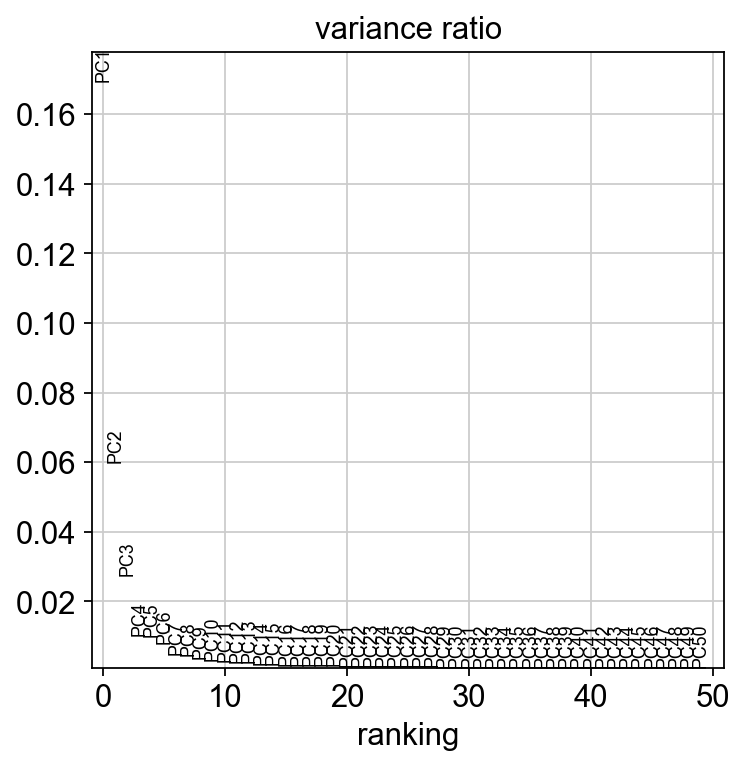

In [42]:
# adata = qc(adata)
adata = preprocess(adata)

In [43]:
sc.pp.neighbors(adata,n_neighbors=20,n_pcs=10)

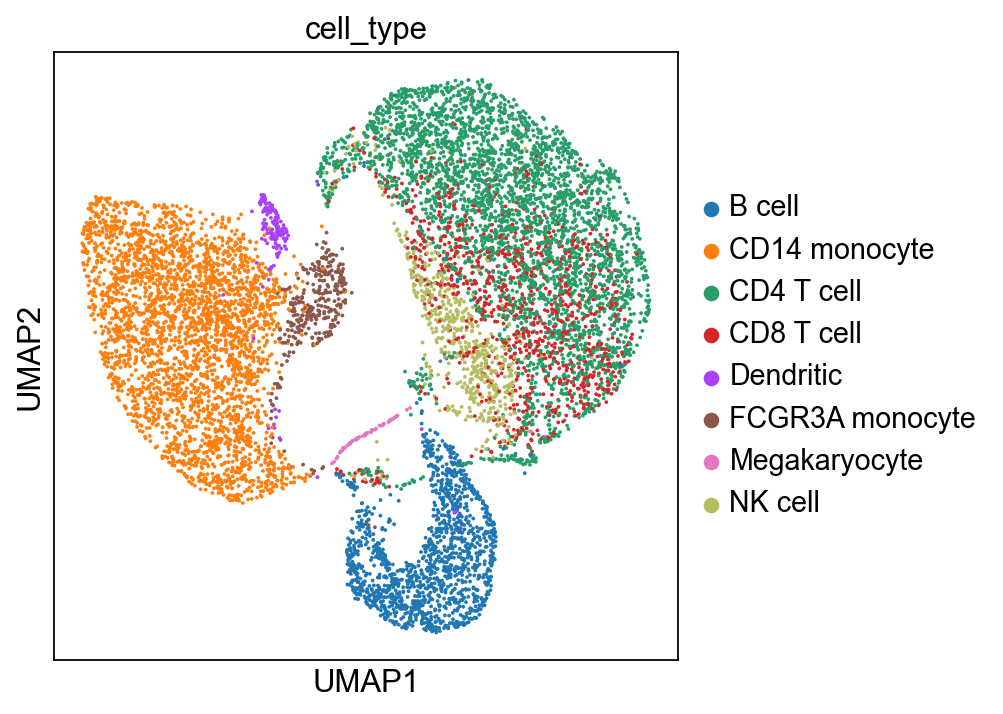

In [44]:
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

In [70]:
# Run infercnv

# Remove genes with empty gene positions
adata = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)].copy()

# cell type annotation
reference_key = 'cell_type'

# cell type categories to include
reference_cat = [
    'B cell',
    'CD14 monocyte',
    'CD4 T cell',
    'CD8 T cell',
    'Dendritic',
    'NK cell'
]

cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat)

  0%|          | 0/3 [00:08<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 0)

In [61]:
print("adata shape:", adata.shape)
print("adata.var columns:", adata.var.columns)
print("adata.obs columns:", adata.obs.columns)
print("Unique cell types in reference_key:", adata.obs['cell_type'].unique())

adata shape: (10309, 19693)
adata.var columns: Index(['gene_ids', 'feature_types', 'genome', 'mt', 'ribo',
       'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts',
       'total_counts', 'n_cells', 'chromosome', 'start', 'end', 'strand'],
      dtype='object')
adata.obs columns: Index(['n_genes_by_counts', 'total_counts', 'total_counts_ribo',
       'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_genes',
       'n_counts', 'cell_type', 'simulated_cnvs'],
      dtype='object')
Unique cell types in reference_key: ['CD4 T cell', 'Dendritic', 'CD14 monocyte', 'NK cell', 'B cell', 'CD8 T cell', 'FCGR3A monocyte', 'Megakaryocyte']
Categories (8, object): ['B cell', 'CD14 monocyte', 'CD4 T cell', 'CD8 T cell', 'Dendritic', 'FCGR3A monocyte', 'Megakaryocyte', 'NK cell']


In [66]:
# Check for invalid chromosome entries
invalid_chromosomes = adata.var['chromosome'].isna().sum()
print(f"Number of invalid chromosome entries: {invalid_chromosomes}")

# Print unique chromosome names
print("Unique chromosome names:")
print(adata.var['chromosome'].unique())

Number of invalid chromosome entries: 0
Unique chromosome names:
['1', 'HSCHR1_1_CTG3', '2', 'HSCHR2_4_CTG1', 'HSCHR2_1_CTG1', ..., 'GL000195.1', 'GL000219.1', 'KI270734.1', 'GL000218.1', 'HG1343_HG173_HG459_PATCH']
Length: 84
Categories (84, object): ['1', '2', '3', '4', ..., 'HSCHRX_3_CTG3', 'KI270734.1', 'X', 'Y']
